# Lecture 27 - Reproducible Data Science Projects

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2023-Python-Programming-for-Data-Science/blob/main/docs/Lectures/Theme_4-Model_Deployment/Lecture_27-Reproducible_Projects/Lecture_27-Reproducible_Projects.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2023-Python-Programming-for-Data-Science/blob/main/docs/Lectures/Theme_4-Model_Deployment/Lecture_27-Reproducible_Projects/Lecture_27-Reproducible_Projects.ipynb) 

<a id='top'></a>

- [27.1 Introduction](#27.1-introduction)
- [27.2 Docker](#27.2-docker)
    - [27.2.1 Installing Docker](#27.2.1-installing-docker)
- [27.3 Hello World in Docker](#27.3-hello-world-in-docker)
- [27.4 Scikit-learn Models in Docker](#27.4-scikit-learn-models-in-docker)
- [27.5 TensorFlow-Keras Models in Docker](#27.5-tensorflow-keras-models-in-docker)
- [27.6 Docker Registries and Repositories](#27.6-docker-registries-and-repositories)   
- [Appendix: Kubernetes](#appendix:-kubernetes)   
- [References](#references)

## 27.1 Introduction <a id="27.1-introduction"/>

Ensuring the reproducibility of Data Science projects is important for several reasons. One is that our customers (internal within your organization, or external) may use different operating systems, code dependencies, hardware, and they should be able to use our developed product and obtain the expected results. Another reason is collaborative development, where we may need to share our code with collaborators, and ensuring reproducibility of our codes requires information about the full environment in which the code was developed. 

Predictions of Machine Learning models depend on the model architecture and parameters, code, libraries and dependencies needed to run the code. Ensuring reproducibility is a challenge that can affect the performance if not addressed. Regarding the model architecture and weights, we can simply save and load them, to ensure that the same model is used and that the predictions are consistent. Regarding code, we can use fixed random seeds and version control to ensure that the same data and code are used for training the model and making predictions. Dealing with code libraries and dependencies is more challenging, because libraries are updated frequently, and the model behavior can change, or even worse, the code can crash with some updates. To address this issue requires to apply a strategy for constraining the environment in which the model is developed and deployed.   

The main strategies to constrain the libraries and dependencies include:

1. Interoperable standards,
2. Virtual environments,
3. Docker containers. 

The first strategy involves standards like Open Neural Network Exchange (ONNX). ONNX is an open-source format for representing neural networks that allows interoperability between different frameworks (such as PyTorch and TensorFlow), or between different platforms. E.g., it allows a model trained in PyTorch to be imported and used for predictions in TensorFlow. Despite the potential, this strategy requires to frequently update the tools as the frameworks are updated, it has limited support for some operations in neural networks, it often has bugs in the conversions between the frameworks, and the performance of models can differ after the conversion to a target framework. 

The second strategy is to use virtual environments in Python or Conda. Although using virtual environments can constrain the environment (e.g., Python dependencies), they provide only partial solution, since operating system-level dependencies or dependencies like CUDA that involve interaction with hardware may be outside the scope of virtual environments and cannot be addressed with this strategy. 

The third strategy relies on using Docker containers and it is widely adopted at present time. **Docker** is an open-source library that uses containers to constrain project dependencies. Container is a standardized unit of fully packaged software used for local development, shipping code, and deploying systems.

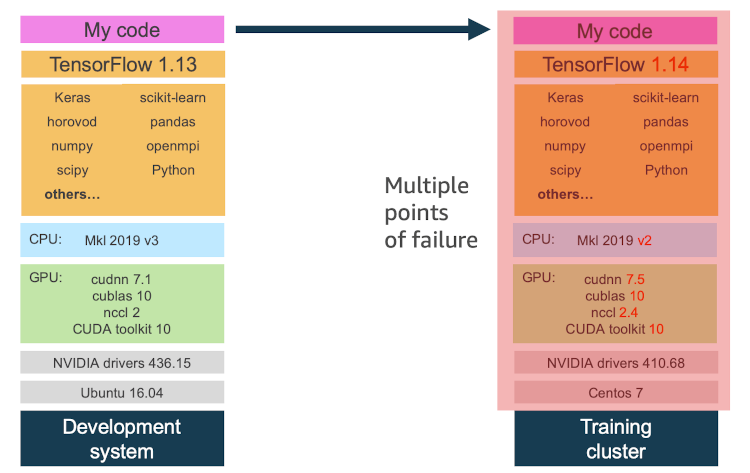## 27.2 Docker <a id="27.2-docker"/>

An example of the reproducibility challenge with Data Science projects is shown in the next figure, depicting the multiple points for failure when we move our code to a cluster. These issues can include different versions of libraries, dependencies, drivers, or operating system. The main advantages of Docker containers are that they contain all dependencies, including hardware libraries, and ensure reproducible and consistent code performance. 

<img src="images/points_of_failure.png" width="600">

*Figure: Reproducibility challenge.*

Characteristics of containers are: 

- Portable, since the containers are detached from the underlying hardware and the platform that runs them. This allows to seamlessly port our code and projects from our local machine to other machines (e.g., that may run on different operating system or use different hardware), or to external clusters that offer GPU resources. Portability enables teams to easily collaborate on projects and experiment with new software and frameworks, without the need to spend time setting up the environment for running code. 
- Lightweight, since the containers don't require a full operating system, and they share the kernel of the host operating system.
- Scalable, applications can easily be scaled by adding or removing container instances.
- Secure, the application and its dependencies run in an isolated environment, hence the containers are less exposed to attacks. 
- Facilitate deployment, where Data Science projects can be easily containerized and deployed for consumption by the end-users, with consistent performance between development and production environments.

Note also that there are notable differences between containers and Virtual Machines (VMs). VMs run a complete operating system with its own kernel, and each VM operates as an independent instance with its dedicated resources. Containers do not require hypervisor or hardware virtualization, and they use the host's operating system. This means that containers only need to package the application, its dependencies, and the minimal required components to run, without duplicating the entire operating system. Because of that, containers are smaller in size and faster to boot. VMs offer stronger isolation than containers, because each VM operates independently of the host, whereas containers share the same kernel with the host. Orchestration tools for containers such as Kubernetes and Docker Swarm can be used to manage and scale containerized applications across clusters of machines, whereas orchestration of VMs is more complex. Containers are well-suited for microservices architectures, continuous integration and deployment (CI/CD), and scalable, distributed applications, while VMs are used for running legacy applications, and environments requiring strong isolation or using multiple operating systems.

Important concepts for working with Docker include:

- *Dockerfile* - script that defines the steps to build a Docker image.
- *Image* - is a built package containing the application and its dependencies.
- *Container* - is an instance where the Docker image is run.

We will explain these concepts through several examples in the following sections. 

### 27.2.1 Installing Docker <a id="27.2.1-installing-docker"/>

Using Docker on a Windows machine can be done by the app [Docker Desktop for Windows](https://docs.docker.com/desktop/install/windows-install/). This requires to download the app and install it. Depending on the Windows operating system, it may also require to install updates for Windows Subsystem for Linux, and other libraries. It is also possible to install Docker from the command line. Please follow the instructions on the [Docker page](https://docs.docker.com/desktop/install/windows-install/) for more detailed information.

## 27.3 Hello World in Docker <a id="27.3-hello-world-in-docker"/>

Let's start with a simple "Hello World" example in Docker, where the goal is to create a container with a Python file to print the Hello World! statement.

### Step 1: Create a Python Script

For this purpose, we will create the Python script shown below that has just one line of code, and we will save it under the name `hello_world.py` in the folder `demo1`. 

<img src="images/hello_world_script.png" width="300">

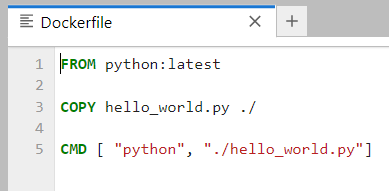### Step 2: Create a Dockerfile

**Dockerfiles** provide instructions for defining custom environments for our projects. I.e., for each particular project we will define the required software packages and libraries in a Dockerfile, and we will use the Dockerfile to build a Docker image.  

It is common to start the Dockerfile with a *base environment*, which can simply include the latest Python version. Alternatively, as a base environment we can import pre-build environments by other developers. Docker provides access to *Docker Hub*, which is a registry with a large number of Docker images that have been published by other developers, and allows to directly import and take advantage of many pre-built environments.  

Dockerfiles are plain text files, and for this simple project the Dockerfile is shown below: 

- The first line uses the `FROM` command to instruct Docker to use Python as a base image for the environment. The term `latest` instructs Docker to retrieve the image of the latest official Python version. Docker will first check if we have the latest Python version installed on our machine, and if we don't, Docker will automatically download the image from Docker Hub. Alternatively, if we wanted to work with an earlier Python version, we can just write `FROM python:3.5` or `FROM python:2.7`, for example. 
- The second line uses the `COPY` command to copy the created `hello_world.py` file from the local folder on my computer to the filesystem of the Docker image. The notation `./` is used for the root directory of the Docker image. The syntax is `COPY source_directory destination_directory`. 
- The third line uses the `CMD` command to execute the `hello_world.py` script from the root directory in the image when the container is run. 

<img src="images/dockerfile1.png" width="300">

The file needs to be saved under the name `Dockerfile`. 
The organization of the `Demo1` folder is:
```
Demo1
    ├── Dockerfile
    ├── hello_world.py
```

### Step 3: Build the Docker Image

**Docker image** is a template that contains instructions for creating a container that runs on the Docker platform. It provides a convenient way to package up code and preconfigured environments, which we can use for our own private use or share publicly with other Docker users. 

To build a Docker image from the Dockerfile, we will use the following code.

```
docker build -t demo1 .
```

Docker code begins with the keyword `docker`. The command `build` specifies to build a Docker image. `-t` is used to set a tag to the image, and in this case we tag the image with the name `demo1`. The dot `.` at the end of the line specifies to build the image by using the Dockerfile that is located in the current directory where `hello_world.py` script is located. 

<img src="images/build1.png" width="800">

The Docker image that we just built represents a collection of files that are required for an operational environment. Each of the files that make up a Docker image is referred to as a *layer*. The images can contain multiple application codes and dependencies, i.e., they can have multiple layers. 

In general, it is possible to build a Docker image by typing Docker commands interactively in the command line, and creating a Dockerfile is not required. However, Dockerfiles provide convenience and a documented record of the steps taken to assemble an image.

### Step 4: Run the Docker Container

To run the image, we just use the `run` command, followed by the image tag `demo1`. This will execute the `hello-world.py` script in the container, which will display `Hello World!` in the terminal.

```
docker run demo1
```

<img src="images/run1.png" width="1000">

In summary, we created a container that is independent of our local machine and that has an implementation of Python, and we displayed a message in that container. 

**Conclusion**

The figure below shows the basic steps in Docker. We begin with a Dockerfile that contains the required commands to build a custom Docker image for our application. The Docker image is a custom environment, that contains the required code, libraries, and dependencies for the application. Docker containers are run using the Docker image. Within a container, the image comprises all the required files to run the application. By using containers, applications are isolated from other processes, preventing other processes from affecting the current application.

<img src="images/img1.png" width="500">

Docker containers have an analogy with cargo containers used for shipping products. Once we place our product (code and dependencies) in the container, we can ship it by boat or train (laptop or cloud), and when it gets to its destination, it continues to function (run) just as before the shipment was made.

And one more note is that Docker has an official `Hello World` image, which can be run directly from the terminal, and it is typically used by users when they install Docker for the first time to verify that it works properly. The following figure displays the output of the `Hello World` image.

<img src="images/docker_helloworld.png" width="1000">

## 27.4 Scikit-learn Models in Docker <a id="27.4-scikit-learn-models-in-docker"/>

In this section, we will learn how to create a container for running a scikit-learn model. 

To demonstrate the concept, we will use the *California Housing Dataset* that is available in scikit-learn, and that we also used in Lecture 15 when we studied regression with ANNs. The dataset contains 20,640 records about housing prices in California, and it includes 9 features related to the number of rooms, population, latitude, longitude, and similar information. The target column is the median value of the house. This is a regression problem, where the goal is for a given set of input features to predict the housing price. 

For this task, we will create a new folder, containing a `Dockerfile` to build the Docker image, `train.py` script for loading the dataset, training the model, and saving the model parameters, and `inference.py` script for loading the trained model and predicting on test instances. 

```
Demo2-sklearn
    ├── Dockerfile
    ├── train.py
    ├── inference.py
```

### Step 1: Create `Train.py` script

The code in `train.py` script is shown below (note that if you run the cell in this Jupyter notebook, it will give errors, because the code is intended to be executed as a script). 

This script is easy to understand. We import the necessary libraries, load the data, fit a Gradient Boosting Model, and save the model. From the imported `joblib` package we used the `dump` method to serialize the model parameters and save them at the `MODEL_PATH` location. Also note that the `train.py` script defines the paths to the directory `MODEL_DIR` and saved model `MODEL_FILE`. This will allow to pass the path to Docker at build time, and embed these locations into the Docker image. The `MODEL_DIR` and `MODEL_FILE` environmental variables are defined in the Doockerfile in the next section. Then, when the container is run, the script will read the locations of the files from the image, and use the saved model to predict on new data during inference. 

In [ ]:
# Import libraries
import numpy as np
from sklearn import ensemble
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import os
from joblib import dump

# Load and split data
housing = fetch_california_housing(as_frame=True).frame
X = housing.drop('MedHouseVal', axis=1)
y = housing['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X,  y, random_state=13, test_size=0.2)

# Fit regression model
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

# Directory paths 
MODEL_DIR = os.environ["MODEL_DIR"]
MODEL_FILE = os.environ["MODEL_FILE"]
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

# Save the model
dump(model, MODEL_PATH)

### Step 2 Create `Inference.py` script

The script `inference.py` is very similar to `train.py`, except that the trained model is loaded, and in the last few lines of code, the loaded model is used to predict the price for the first 10 instances from the test dataset. The output includes both the predicted prices and the ground-truth prices from `y_test`. 

In [ ]:
# Import libraries
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import os
from joblib import load

# Load and split data
housing = fetch_california_housing(as_frame=True).frame
X = housing.drop('MedHouseVal', axis=1)
y = housing['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X,  y, random_state=13, test_size=0.2)

# Directory paths 
MODEL_DIR = os.environ["MODEL_DIR"]
MODEL_FILE = os.environ["MODEL_FILE"]
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

# Load model
model = load(MODEL_PATH)

# Run inference
y_pred = model.predict(X_test[:10])
print("Predicted price by the model:", np.around(y_pred,1))
print("Ground-truth price:", np.array(y_test[:10]))

## Step 3: Create `Dockerfile`

The `Dockerfile` for this project is provided below, and contains the following parts:

- `FROM jupyter/scipy-notebook` uses a pre-built image `jupyter/scipy-notebook` as a base image. The image contains a `python` installation, `scipy`, and other libraries to facilitate working with `Jupyter`. This image will be downloaded from Docker Hub. 
- The next lines are used to first create a new directory called `model` where the trained model will be saved. Afterward, 2 environment variables are defined for `MODEL_DIR` and `MODEL_FILE` that will reference the newly created directory and the name of the saved model. The directory `/home/jovyan/` was set in the imported base image `jupyter/scipy-notebook`.
- The `COPY` commands are used to copy the `train.py` and `inference.py` scripts from our local machine to the working directory of the image. 
- `RUN python train.py` will execute the script to train and save the model. This will ensure that the model is saved at a specific location , and it is ready to predict on new data when the image is run. An advantage is that if the model training fails, it will happen when we build the image rather than at run time, which allows to debug the issue. 
- `CMD [ "python", "./inference.py"]` will execute the `inference.py` script when we run the container from the image. 

In [ ]:
FROM jupyter/scipy-notebook

RUN mkdir model
ENV MODEL_DIR=/home/jovyan/model
ENV MODEL_FILE=model.joblib

COPY train.py ./train.py
COPY inference.py ./inference.py

RUN python train.py

CMD [ "python", "./inference.py"]

#### Dockerfile Commands

Common commands that are used in Dockerfiles are shown in the next table. 

|**Command**|**Purpose**|
|--|--|
|FROM|To specify the base image.|
|WORKDIR|To set the working directory.|
|RUN|To install any libraries and packages required for the container.|
|COPY|To copy files or directories from a specific location.|
|ADD|To add remote URLs and unpack compressed files.|
|ENTRYPOINT|To specify commands to be executed when the container starts.|
|CMD|Commands the container executes.|
|EXPOSE|To define the port to access the container application.|
|LABEL|To add metadata to the image.|

### Step 4: Build the Docker Image

Next, we will build a Docker image from the Dockerfile, similarly to the previous example. Often, tags in the form `image_name:tag_name` are used, as in this case, where we assigned the image name `demo2-sklearn` and we assigned the tag name `0.1`. The tag name allows to apply versioning to Docker images, where, for instance, we can assign tag name `0.2` to the next version of image, or `1.0` if significant updates have been applied. If the tag name is omitted, Docker will pull the most recent image version, which is identified by the tag `latest`. 


```
docker build -t demo2-sklearn:0.1 .
```

To list the Docker images that we have built, we can use, well, `docker images` shown in the figure. Note that the image `demo1` has the tag name `latest`, and the image `demo2-sklearn` has the tag name `0.1`.

<img src="images/images_list.png" width="1000">

Now that we have an image that contains a saved trained model, next, we will run a container to make predictions using the model. 

### Step 5: Run the Docker Image

We run the image by using `docker run` and the name of the image. This will load the saved model, make predictions, and display the predicted house prices for the first 10 records in the test dataset. For comparison, the target prices for the first 10 records are also displayed. In a real-world case, the model will make predictions on new data samples (e.g., the price for house information that may be inputted by a realtor). 

```
docker run demo2-sklearn:0.1
```

<img src="images/run2.png" width="1000">

Note as well that we can launch multiple containers from one Docker image, with the containers maintaining their own individual state although sharing the same image. The changes to each individual container are stored in a *container layer*.

### Docker Desktop

Docker Desktop for Windows also provides lists of all created images, containers, and other related information. For instance, in the Containers section, we can see the two containers that we run `demo1` and `demo2-sklearn` with tag names `latest` and `0.1`, respectively. 

<img src="images/docker_desktop.png" width="1000">

## 27.5  TensorFlow-Keras Models in Docker <a id="27.5-tensorflow-keras-models-in-docker"/>

One more similar example follows, which uses TensforFlow-Keras libraries for creating a Conv Net model for predicting the items in the Fashion MNIST dataset.

The organization of the folder is as follows:

```
Demo3-mnist
    ├── Dockerfile
    ├── mnist_train.py
    ├── mnist_inference.py
    ├── requirements.py
```

### Step 1: Create `mnist_train.py` script

The script contains code for creating a Convolutional Neural Network model, compiling and training the model, and saving the model in a `cnn_model.keras` file. 

In [1]:
# Import modules
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Load the dataset
mnist_fashion = keras.datasets.fashion_mnist
(training_images, training_labels), (test_images,test_labels) = mnist_fashion.load_data()

# Scaling 
training_images = training_images/255.0

# Define the layers in the model
inputs = Input(shape=(28, 28, 1))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=64, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
flat = Flatten()(pool1)
dense1 = Dense(128, activation='relu')(flat)
dropout1 = Dropout(0.5)(dense1)
outputs = Dense(10, activation='softmax')(dropout1)
# Define the model with inputs and outputs
cnn_model = Model(inputs, outputs)

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
cnn_model.fit(training_images, training_labels, epochs=5)

# Save the weights
cnn_model.save("cnn_model.keras")

4422102/4422102 [==============================] - 1s 0us/step
Epoch 1/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.4081 - accuracy: 0.8565
Epoch 2/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2771 - accuracy: 0.8999
Epoch 3/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2353 - accuracy: 0.9140
Epoch 4/5
1875/1875 [==============================] - 61s 32ms/step - loss: 0.2074 - accuracy: 0.9247
Epoch 5/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.1841 - accuracy: 0.9324


### Step 2 Create `mnist_inference.py` script

The script `mnist_inference.py` is similar, where the saved model is loaded, and it is used to predict the digits in the first 10 images in the test dataset. For comparison, the real labels for the 10 test images are displayed as well. 

In [ ]:
# Import modules
import numpy as np
import tensorflow
import tensorflow.keras as keras
from keras.models import load_model

# Load the dataset
mnist_fashion = keras.datasets.fashion_mnist
(training_images, training_labels), (test_images,test_labels) = mnist_fashion.load_data()

# Scaling 
test_images = test_images/255.0

# loading the weights
cnn_model.load_model("cnn_model.keras")

# Predict
print("Predict the digit in the first 10 images in the test dataset")
y_pred = cnn_model.predict(test_images[:10])
print("Predicted image label:", np.argmax(y_pred,1))
print("Ground-truth image label:", test_labels[:10])

### Step 3: Create `Dockerfile`

The `Dockerfile` is similar to the example in the previous section. It uses a Python 3.7.5 version, where `-slim` indicates to use lightweight image of Python. This will reduce the size of the image, but it may require to install additional libraries. Also note that the required libraries are provided in a `requirements.txt` file, instead of typing all required libraries individually in the Dockerfile. The rest of the lines copy the required files to the image, and then run the `requirements.txt` file to install the libraries in the image, and the `mnist_train.py` file to train the model and save it in the image.

```
numpy===1.21.5
keras===2.9.0
tensorflow===2.9.1
```



In [ ]:
FROM python:3.7.5-slim

COPY requirements.txt ./requirements.txt
COPY mnist_train.py ./mnist_train.py
COPY mnist_inference.py ./mnist_inference.py

RUN pip install -r requirements.txt
RUN python mnist_train.py

CMD [ "python", "./mnist_inference.py" ]

### Step 4: Build and Run the Docker Image

Next, we will build the image `demo3-mnist` with a tag name `v1.0.0` and run it. The output is shown below. 

```
docker image build -t demo3-mnist:v1.0.0 .

docker run demo3-mnist:v1.0.0  
```

<img src="images/run3.png" width="1000">

## 27.6 Docker Registries and Repositories <a id="27.6-docker-registries-and-repositories"/>

**Container repositories** are the physical locations where Docker images are  stored. Each repository contains different versions of each image, where each image is referenced by a different tag. For example, on Docker Hub, `mysql` is a repository that contains different versions of the Docker image for `MySQL`.

**Container registry** is a set of repositories. The main types of container registries are:

- Docker Hub: it is the official public container registry maintained by Docker, which hosts over 100,000 container images created by software vendors, open-source projects, and Docker’s community of users.  
- Third-party registry services: are managed registries that allow users to store and share their Docker images. Examples of third-party registries include Azure Container Registry, Google Container Registry, Amazon ECR, Red Hat Quay, and JFrog Container Registry.
- Self-hosted registries: are managed by organizations that prefer to host container images on their own on-premises infrastructure, typically due to security, compliance concerns, or lower latency requirements. Running self-hosted registries requires to deploy a registry server.

### Pull and Push images on Docker Hub

As we mentioned, Docker Hub allows users to host and manage their own images, where Docker images can be easily shared between collaborators, allowing every collaborator to use reproducible environment. 

To push built images to the Docker Hub registry, users will need to first log in to Docker Hub and then use the code to push the image. 

```
docker login --username=your_username --password=your_password
docker push username/image:tag
```

Also, pulling images by other developers from Docker Hub is very easy, and allows to use other images with little or no modification. 

```
docker pull username/image:tag
```

### Benefits of Docker

- Code and dependencies can be packaged together into portable containers that can be run on a variety of different hosts, regardless of the hardware or operating system. 
- Provides versioning of build environments, where image versions can be tracked and rolled back.
- Allow to replicate the working environment that is needed to train and deploy machine learning model on any system, and removes the reproducibility challenges. 
- Trained machine learning models can be easily wrapped into an API in a container, and deployed to remote servers. 

## Appendix: Kubernetes <a id="appendix:-kubernetes"/>

**The material in the Appendix is not required for quizzes and assignments.**

Although Docker containers provide the tools for ensuring reproducibility, when there are multiple containers that need to be run on a system consisting of multiple machines, managing the containers can become difficult. **Kubernetes** is a platform for orchestration of containers, that manages the coordination and communication between multiple containers. That is, for a set of containers and a set of available machines on a cluster, Kubernetes determines the optimal assignment of machines for each container. This is advantageous because it allows the system to function without the need for human intervention. E.g., if one container shuts down unexpectedly, it will run another container to replace its function. 

The combination of Docker containers and Kubernetes orchestrator is well suited for developing and deploying *microservices*, where software applications are designed as a set of multiple, small, and decoupled services, that can be scaled and updated independently. 

### Pod

The building block of Kubernetes is a **pod**, consisting of one or multiple related containers, shared networking, and shared volume. The pods are designed as temporary objects, that will persist only for some period of time. Each pod is assigned a unique IP address to communicate with it. Volume is a storage location that is outside of a container, and allows to store data independently from the container. If a container is deleted, the volume is not deleted, and it can be used by other containers.

<img src="images/pod.png" width="400">

### Deployment

**Deployment** object consists of several pods, which include a *template* pod and multiple *replicas* pods. Having replicas of pods allows to replace any crashing pods at any time. 

<img src="images/deployment.png" width="1000">

### Service

**Service** object directs traffic to the pods, by balancing the incoming traffic between multiple pods. Also, if some pods crash, the service will launch new pods and it will direct the traffic to the new pods. Service also allows clients to access the pods without the need to know specific information about the pods (such as IP address or implementation). 

<img src="images/service.png" width="1000">

### Ingress

**Ingress** object controls which services that are exposed to external traffic. This allows to make certain services publicly available (e.g., predictions by a machine learning model) and keep certain services private (e.g., pods for training and updating the model with new data). In general, ingress refers to data entering a network, and egress is data leaving the network. 

<img src="images/ingress.png" width="1000">

### Control Plane

Kubernetes **control plane** controls how workloads are executed, monitored, and maintained on a cluster. A figure showing the elements in a control plane is shown below. 

The cluster has a *master node* and multiple *worker nodes* that run the applications. For instance, a cluster can have several GPU-optimized worker nodes for model training and CPU-optimized worker nodes for making predictions.

The master node includes: scheduler - for assigning objects to available machines, controller manager - monitors the state of the cluster and compares the current state to the desired state, API server - communicates with a client and accepts requests, and  etcd component - stores the current state of the cluster.  

Each worked node includes a control component consisting of a kubelet and kube-proxy. The kubelet communicates with the API server to find out which workloads have been assigned to the node, and runs the pods to complete the assigned workloads. Kube-proxy enables containers from different pods to communicate with each other.

<img src="images/control_plane.png" width="1000">

The Kubernetes system is designed to handle any failures in the cluster. For example, if the master node is down, the applications will not be immediately affected, and a new master node will be launched to continue the operation of the system. 

Kubernetes are designed to orchestrate large number of workloads that may include multiple Data Science projects, distributed across clusters of servers, and serving continuously a large number of end-users. It is not the optimal solution for working with a single machine to run a lightweight load that does not need frequent changes and updates. 

## References <a id="references"/>

1. Full Stack Deep Learning course, Lecture 11: Deployment & Monitoring, available at [https://fullstackdeeplearning.com/spring2021/lecture-11/](https://fullstackdeeplearning.com/spring2021/lecture-11/).
2. ML in Production, Docker for Machine Learning, by Luigi Patruno, available at: [https://mlinproduction.com/docker-for-ml-part-1/](https://mlinproduction.com/docker-for-ml-part-1/).
3. A Beginner’s Guide to Understanding and Building Docker Images, available at: [https://jfrog.com/knowledge-base/a-beginners-guide-to-understanding-and-building-docker-images/](https://jfrog.com/knowledge-base/a-beginners-guide-to-understanding-and-building-docker-images/).
4. Machine Learning with Docker, Demonstrations about Using Docker for Machine Learning, available at: [https://github.com/BINPIPE/docker-for-ml](https://github.com/BINPIPE/docker-for-ml).
5. An introduction to Kubernetes, by Jeremy Jordan, available at: [https://www.jeremyjordan.me/kubernetes/](https://www.jeremyjordan.me/kubernetes/).


[BACK TO TOP](#top)